In [2]:
!unzip DCGRU_github.zip

Archive:  DCGRU_github.zip
  inflating: dcgru_cell_tf2.py       
   creating: lib/
  inflating: lib/matrix_calc.py      
   creating: synth_signal/
  inflating: synth_signal/gen_signal.py  
  inflating: synth_signal/road_network.py  


# Import libraries

In [12]:
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt
import pickle

from synth_signal.gen_signal import generate_signal
from dcgru_cell_tf2 import DCGRUCell

# Graph

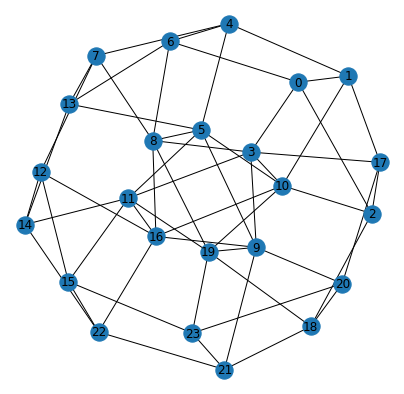

In [4]:
N = 3
G = nx.grid_2d_graph(N,N)
G = nx.line_graph(G.to_directed())
G = G.to_undirected()

node_list = list(G.nodes())
for i, old_id in enumerate(node_list):
  map_labels = {}
  map_labels[old_id] = i
  nx.relabel_nodes(G, map_labels, copy=False)

pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(7,7))
nx.draw_networkx(G, pos=pos)
plt.axis('off')
plt.show()

# Signal

In [22]:
signal = pickle.load(open('signal.pickle','rb'))

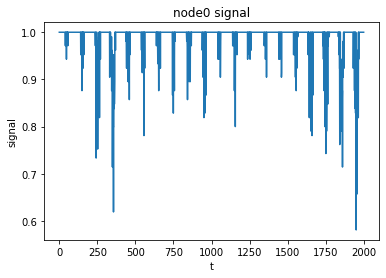

In [24]:
for i in G.nodes():
  sp_node0 = [sp[i] for sp in signal]
  plt.plot(list(range(len(signal))), sp_node0)
  plt.title('node' + str(i) + ' signal')
  plt.xlabel('t')
  plt.ylabel('signal')
  plt.show()
  break

# Model testing (one signal)

In [25]:
num_nodes = len(G)
G_adj_mx = nx.to_numpy_matrix(G) + np.diag(np.ones(num_nodes))

seq_len = 8
horizon_list = [2, 4, 8]
sign_len = len(signal)
train_val_split = int(sign_len*0.75)

In [26]:
model_performance = {}
for horizon in horizon_list:
  X = []
  y = []
  for i in range(100,len(signal)-(seq_len+horizon)):
    X.append(signal[i:i+seq_len])
    y.append(signal[i+seq_len+horizon])
  X = np.array(X)
  y = np.array(y)

  X_train, y_train = X[:train_val_split], y[:train_val_split]
  X_valid, y_valid = X[train_val_split:], y[train_val_split:]
  X_train_dcgru = np.expand_dims(X_train, -1)
  X_valid_dcgru = np.expand_dims(X_valid, -1)


  K.clear_session()
  ##### Models ####

  # Linear Regression
  model_lin_reg = keras.models.Sequential([
    keras.Input((seq_len, num_nodes)),
    keras.layers.Flatten(),
    keras.layers.Dense(num_nodes)                                 
    ])
  model_lin_reg.compile(loss="mse", optimizer="adam")
  model_lin_reg.fit(X_train, y_train, epochs=50, verbose=0)
  model_performance[("lin_reg", seq_len, horizon)] = model_lin_reg.evaluate(X_valid, y_valid,verbose=0)

  # 1Layer Fully Connected
  model_1L = keras.models.Sequential([
    keras.Input((seq_len, num_nodes)),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_nodes, activation='sigmoid')                                 
  ])
  model_1L.compile(loss="mse", optimizer="adam")
  model_1L.fit(X_train, y_train, epochs=50, verbose=0)
  model_performance[("1L", seq_len, horizon)] = model_1L.evaluate(X_valid, y_valid,verbose=0)

  # GRU
  model_gru = keras.models.Sequential([
    keras.Input((None, num_nodes)),
    keras.layers.GRU(32),
    keras.layers.Dense(num_nodes)
  ])
  model_gru.compile(loss="mse", optimizer="adam")
  model_gru.fit(X_train, y_train, epochs=50, verbose=0)
  model_performance[("gru", seq_len, horizon)] = model_gru.evaluate(X_valid, y_valid,verbose=0)

  # DCGRU
  model_dcgru = keras.models.Sequential([
    keras.Input(shape=(None, num_nodes, 1)),
    keras.layers.RNN(DCGRUCell(units=20,adj_mx=G_adj_mx, K_diffusion=2,
                               num_nodes=num_nodes,filter_type="random_walk")),
    keras.layers.Dense(num_nodes)
  ])
  opt = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
  model_dcgru.compile(loss="mse", optimizer=opt)
  model_dcgru.fit(X_train_dcgru, y_train, epochs=50, verbose=0)
  model_performance[("dcgru", seq_len, horizon)] = model_dcgru.evaluate(X_valid_dcgru, y_valid,verbose=0)

In [27]:
model_performance # (model, seq_len, horizon)

{('1L', 8, 2): 0.016165047883987427,
 ('1L', 8, 4): 0.016485080122947693,
 ('1L', 8, 8): 0.016158511862158775,
 ('dcgru', 8, 2): 0.006863653194159269,
 ('dcgru', 8, 4): 0.007671104744076729,
 ('dcgru', 8, 8): 0.010491236113011837,
 ('gru', 8, 2): 0.010003316216170788,
 ('gru', 8, 4): 0.010487784631550312,
 ('gru', 8, 8): 0.012757492251694202,
 ('lin_reg', 8, 2): 0.014392169192433357,
 ('lin_reg', 8, 4): 0.016301775351166725,
 ('lin_reg', 8, 8): 0.017656683921813965}

# Model testing (performance averaged over multiple signals)

In [28]:
model_performance = {}
for n in range(10):
  signal, _, _ = generate_signal(G)
  for horizon in horizon_list:
    X = []
    y = []
    for i in range(100,len(signal)-(seq_len+horizon)):
      X.append(signal[i:i+seq_len])
      y.append(signal[i+seq_len+horizon])
    X = np.array(X)
    y = np.array(y)

    X_train, y_train = X[:train_val_split], y[:train_val_split]
    X_valid, y_valid = X[train_val_split:], y[train_val_split:]
    X_train_dcgru = np.expand_dims(X_train, -1)
    X_valid_dcgru = np.expand_dims(X_valid, -1)


    K.clear_session()
    ##### Models ####

    # Linear Regression
    model_lin_reg = keras.models.Sequential([
      keras.Input((seq_len, num_nodes)),
      keras.layers.Flatten(),
      keras.layers.Dense(num_nodes)                                 
      ])
    model_lin_reg.compile(loss="mse", optimizer="adam")
    model_lin_reg.fit(X_train, y_train, epochs=50, verbose=0)
    if n == 0:
      model_performance[("lin_reg", seq_len, horizon)] = model_lin_reg.evaluate(X_valid, y_valid,verbose=0)
    else:
      model_performance[("lin_reg", seq_len, horizon)] = (model_performance[("lin_reg", seq_len, horizon)]*n + model_lin_reg.evaluate(X_valid, y_valid,verbose=0))/(n+1)

    # 1Layer Fully Connected
    model_1L = keras.models.Sequential([
      keras.Input((seq_len, num_nodes)),
      keras.layers.Flatten(),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(num_nodes, activation='sigmoid')                                 
    ])
    model_1L.compile(loss="mse", optimizer="adam")
    model_1L.fit(X_train, y_train, epochs=50, verbose=0)
    if n == 0:
      model_performance[("1L", seq_len, horizon)] = model_1L.evaluate(X_valid, y_valid,verbose=0)
    else:
      model_performance[("1L", seq_len, horizon)] = (model_performance[("1L", seq_len, horizon)]*n + model_1L.evaluate(X_valid, y_valid,verbose=0))/(n+1)

    # GRU
    model_gru = keras.models.Sequential([
      keras.Input((None, num_nodes)),
      keras.layers.GRU(32),
      keras.layers.Dense(num_nodes)
    ])
    model_gru.compile(loss="mse", optimizer="adam")
    model_gru.fit(X_train, y_train, epochs=50, verbose=0)
    if n == 0:
      model_performance[("gru", seq_len, horizon)] = model_gru.evaluate(X_valid, y_valid,verbose=0)
    else:
      model_performance[("gru", seq_len, horizon)] = (model_performance[("gru", seq_len, horizon)]*n + model_gru.evaluate(X_valid, y_valid,verbose=0))/(n+1)

    # DCGRU
    model_dcgru = keras.models.Sequential([
      keras.Input(shape=(None, num_nodes, 1)),
      keras.layers.RNN(DCGRUCell(units=20,adj_mx=G_adj_mx, K_diffusion=2,
                                num_nodes=num_nodes,filter_type="random_walk")),
      keras.layers.Dense(num_nodes)
    ])
    opt = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    model_dcgru.compile(loss="mse", optimizer=opt)
    model_dcgru.fit(X_train_dcgru, y_train, epochs=50, verbose=0)
    if n == 0:
      model_performance[("dcgru", seq_len, horizon)] = model_dcgru.evaluate(X_valid_dcgru, y_valid,verbose=0)
    else:
      model_performance[("dcgru", seq_len, horizon)] = (model_performance[("dcgru", seq_len, horizon)]*n + model_dcgru.evaluate(X_valid_dcgru, y_valid,verbose=0))/(n+1)


In [29]:
model_performance # (model, seq_len, horizon)

{('1L', 8, 2): 0.005757431255187839,
 ('1L', 8, 4): 0.0063469463842920956,
 ('1L', 8, 8): 0.007238734851125628,
 ('dcgru', 8, 2): 0.004945343552390113,
 ('dcgru', 8, 4): 0.004955929552670569,
 ('dcgru', 8, 8): 0.0063928485964424905,
 ('gru', 8, 2): 0.0050294972257688645,
 ('gru', 8, 4): 0.00578094920492731,
 ('gru', 8, 8): 0.006760113930795342,
 ('lin_reg', 8, 2): 0.009424487454816699,
 ('lin_reg', 8, 4): 0.01009641056880355,
 ('lin_reg', 8, 8): 0.013465061807073653}